# Прогнозирование оттока клиентов в сети отелей.

Задача - разработать модель, которая предсказывает отказ от брони. Уложиться в бюджет. 

ход работы:

- загрузка библиотек
- загрузка данных
- обзор данных
- подготовка и анализ данных
- оценка прибыли до внедрения модели
- подготовка признаков для ml
- построение моделей ml
- выбор лучшей модели
- выбор признаков не надежного клиента
- общий вывод и рекомендации

### импорт и загрузка данных

In [1]:
!pip install scikit-learn --upgrade
!pip install -U imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import recall_score,f1_score
from sklearn.utils import shuffle

In [2]:
pd.set_option('display.max_columns', None)

pd.set_option('display.max_rows', None)

In [3]:
df_train = pd.read_csv('/datasets/hotel_train.csv')

df_test = pd.read_csv('/datasets/hotel_test.csv')

In [4]:
df_train.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
3021,3051,1,79.0,2016,March,14,28,1,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
10538,13082,0,5.0,2016,February,9,27,1,1,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,2
19250,27190,1,6.0,2015,September,37,10,0,1,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,A,0,0,Transient,0,0,1
23773,31713,1,7.0,2016,February,9,22,1,0,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
2968,2998,1,106.0,2016,March,13,24,1,3,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,A,0,0,Transient,0,0,4


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
df_test.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
16691,53880,1,159.0,2017,July,29,17,1,0,1.0,0.0,0.0,SC,AUS,TA/TO,0,0,0,A,0,0,Transient,0,0,1
2404,12785,0,123.0,2017,February,7,12,2,2,2.0,0.0,0.0,HB,PRT,TA/TO,1,0,1,D,0,0,Transient,0,3,4
6548,23501,0,210.0,2017,June,24,12,1,2,2.0,0.0,0.0,HB,POL,TA/TO,0,0,0,A,0,0,Contract,0,3,3
19687,85179,0,1.0,2017,February,5,2,0,1,1.0,0.0,0.0,BB,PRT,Direct,0,0,0,A,0,0,Transient,0,0,1
27799,93291,0,4.0,2017,June,23,10,1,1,1.0,0.0,0.0,BB,BEL,Corporate,0,0,0,D,1,0,Transient,0,0,2


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

Данные на месте. Тренировочный фрем в 2раза больше тестого: 65229 строк и 25 колонок и 32412 и 25 колонок соотвествнно. Категореальных столбцов 14, колличественных 11. Целевой столбец is_canceled. 
Сохраним оригинальные ДФ.

In [8]:
old_train_df = df_train.copy()
old_test_df = df_test.copy()

###  предобработка и исследовательский анализ данных

Есть предположение судя по выборкам что в дф разные года. Проверим.Если это так - объеденим в один дф что бы проще было провести предобработку, а после разделить по году. 

In [9]:
print (df_train['arrival_date_year'].unique())
print (df_test['arrival_date_year'].unique())

[2015 2016]
[2017]


In [10]:
df = pd.concat([df_test, df_train], ignore_index=True, sort= False)

с помощью корреляции оценим мультиколллинеарность

<AxesSubplot:>

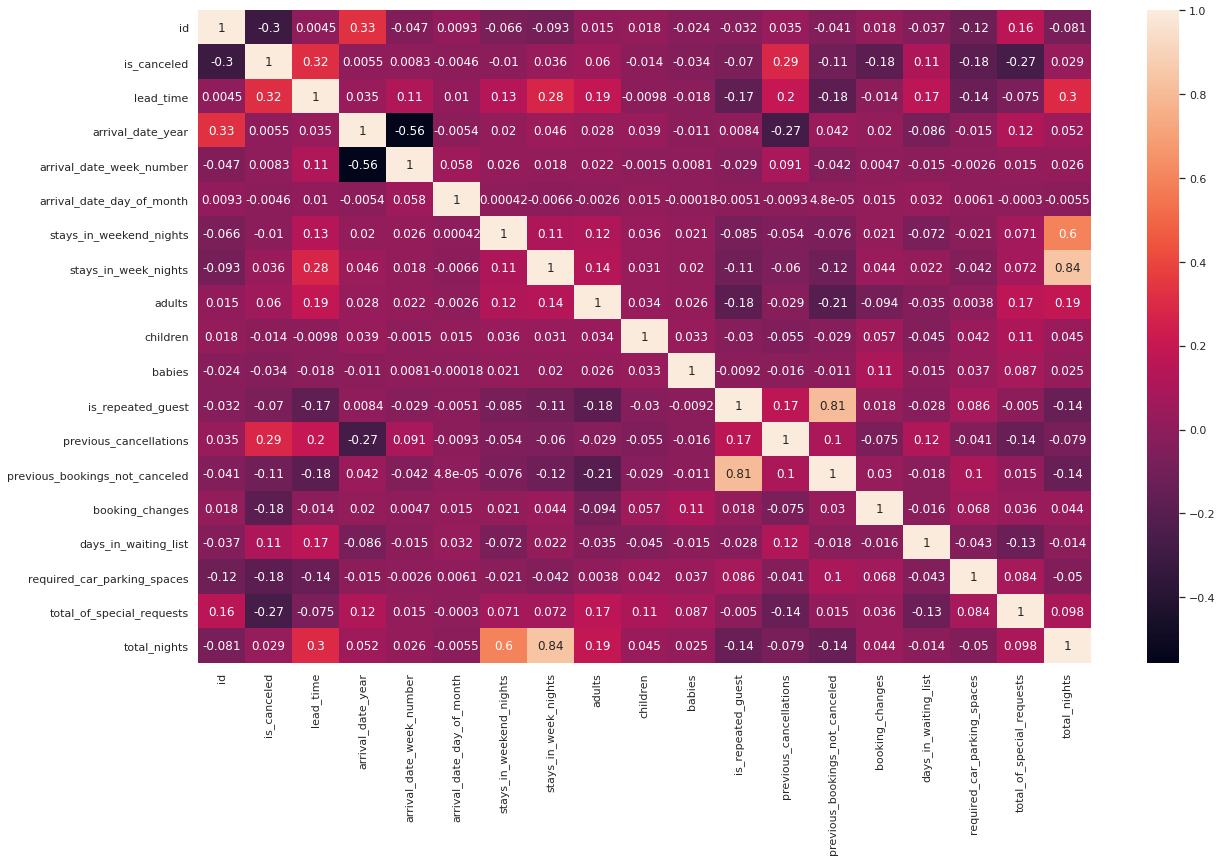

In [11]:
spearman = df.corr(method='spearman')
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(data=spearman,annot=True)

In [12]:
def dell (x):
    if x['stays_in_week_nights'] + x['stays_in_weekend_nights'] != x['total_nights']:
        return (x)

In [13]:
print (df.apply(dell, axis=1))

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
30       None
31       None
32       None
33       None
34       None
35       None
36       None
37       None
38       None
39       None
40       None
41       None
42       None
43       None
44       None
45       None
46       None
47       None
48       None
49       None
50       None
51       None
52       None
53       None
54       None
55       None
56       None
57       None
58       None
59       None
60       None
61       None
62       None
63       None
64       None
65       None
66       None
67       None
68       None
69       None
70       None
71    

присутвует мультиколлинеарность в arrival_date_month - arrival_date_week_number, total_night - stays_in_weekend_nighhts - stays_in_week_nights,is_repeated_guest-previous_bookings_not_canceled. Удалим мультиколлинеарные и малоинформативные столбцы . Отметим также что с признаками нет высокой кореляции целевой переменной. 

In [14]:
df = df.drop(["arrival_date_week_number","id","babies","arrival_date_day_of_month","is_repeated_guest","stays_in_weekend_nights","stays_in_week_nights"], axis = 1)

изменим тип данных на целочисленный в столбцах где это соотвествует логике

In [15]:
df[['lead_time', 'adults', 'children']] = df[['lead_time', 'adults', 'children']].astype('int')

проверим на пропуски

In [16]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
is_canceled,0.000000
lead_time,0.000000
arrival_date_year,0.000000
arrival_date_month,0.000000
adults,0.000000
children,0.000000
meal,0.000000
country,0.000000
distribution_channel,0.000000
previous_cancellations,0.000000


Отлично! Пропусков - нет.
Проверим на дубликаты. 

In [17]:
df.duplicated().sum()

30393

Считаю что не смотря на то что дубликатов много - их стоит удалить. В дф много признаков и врятли есть какое то логическое объяснение дубликатам - кроме ошибки.  

In [18]:
df = df.drop_duplicates().reset_index(drop=True) 

Проверим категориальные столбцы на неявные дубликаты и ошибки.

In [19]:
df.nunique()

is_canceled                         2
lead_time                         372
arrival_date_year                   3
arrival_date_month                 12
adults                              5
children                            4
meal                                5
country                           174
distribution_channel                4
previous_cancellations             15
previous_bookings_not_canceled     72
reserved_room_type                  7
booking_changes                    18
days_in_waiting_list              120
customer_type                       4
required_car_parking_spaces         5
total_of_special_requests           6
total_nights                       10
dtype: int64

In [20]:
df['country'].unique()

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

Признак явно перегружен знчениями. 

In [21]:
df['country'].value_counts(normalize=True)

PRT    0.281614
FRA    0.114055
GBR    0.112791
ESP    0.081430
DEU    0.069861
ITA    0.040135
IRL    0.032135
BEL    0.027614
BRA    0.025592
NLD    0.024759
USA    0.023153
CHE    0.019569
AUT    0.012313
CN     0.012015
CHN    0.010885
SWE    0.009933
POL    0.009279
RUS    0.006558
NOR    0.006052
ROU    0.005502
FIN    0.005324
ISR    0.005309
DNK    0.004863
AUS    0.004416
LUX    0.003123
TUR    0.002885
AGO    0.002751
HUN    0.002602
ARG    0.002587
JPN    0.002513
MAR    0.002439
IND    0.001799
CZE    0.001784
KOR    0.001680
GRC    0.001606
HRV    0.001264
IRN    0.001071
ZAF    0.001011
BGR    0.000952
COL    0.000952
MEX    0.000952
DZA    0.000952
EST    0.000922
LTU    0.000803
UKR    0.000788
CHL    0.000788
NZL    0.000758
MOZ    0.000654
SRB    0.000654
SVK    0.000639
TWN    0.000625
LVA    0.000610
SVN    0.000580
CYP    0.000580
TUN    0.000520
ARE    0.000506
SGP    0.000491
THA    0.000476
SAU    0.000416
PHL    0.000416
LBN    0.000416
EGY    0.000401
NGA    0

почти 30% постояльцев - португальцы. Все страны где меньше 1% заменим на others.  

In [22]:
country = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE', 'AUT', 'CN', 'CHN']
df['country'] = df['country'].apply(lambda x: 'others' if x not in country else x)

In [23]:
df['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

In [24]:
df['meal'].unique()

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

In [25]:
df['meal'] = df['meal'].str.strip()

In [26]:
df['distribution_channel'].unique()

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

In [27]:
df['reserved_room_type'].unique()

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

In [28]:
df['reserved_room_type'] = df['reserved_room_type'].str.strip()

In [29]:
df['customer_type'].unique()

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

Данные впорядке за исключением лишних пробелов в 'meal' и 'reserved_room_type'. 

Проверим количественные переменные на выбросы

In [30]:
for row in df[['booking_changes', 'children', 'lead_time','days_in_waiting_list','total_nights','total_of_special_requests']]:
    Q1 = df[row].quantile(0.25)
    Q3 = df[row].quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    if (df[(df[row] > upper)].any(axis=None)) & (df[(df[row] < lower)].any(axis=None)):
        print(row, ":выбросы есть")
    else:
        print(row, ":выбросов нет")

booking_changes :выбросов нет
children :выбросов нет
lead_time :выбросов нет
days_in_waiting_list :выбросов нет
total_nights :выбросов нет
total_of_special_requests :выбросов нет


общая гистограмма распределения. 

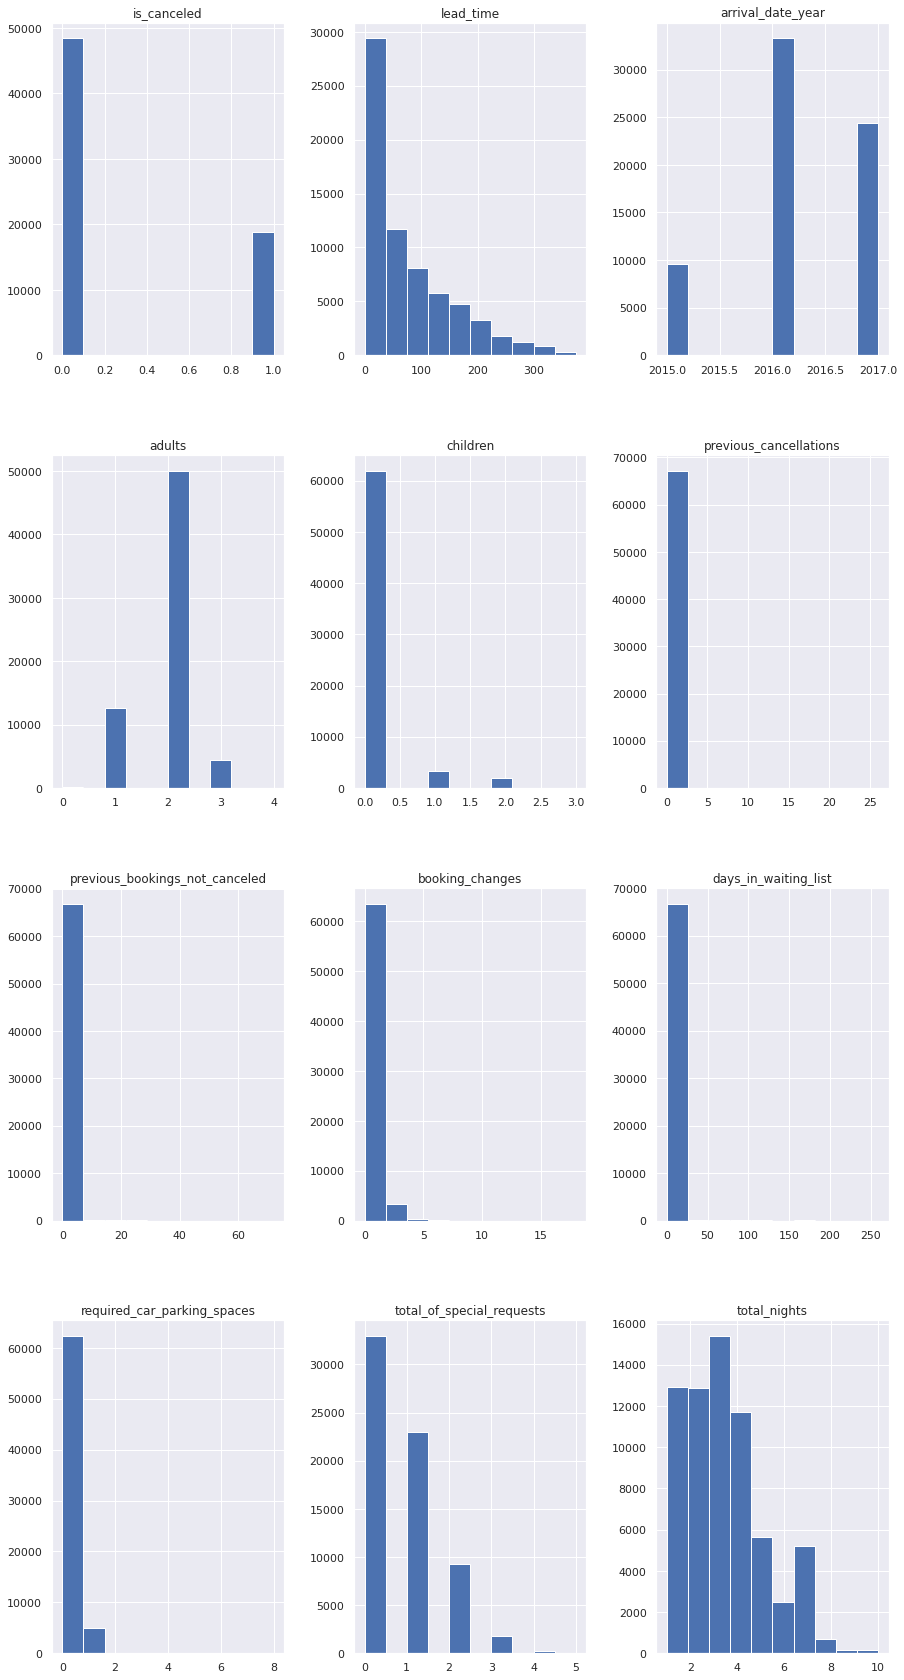

In [31]:
df.hist(figsize=(15, 30))
plt.show()

распределение соответсвует логике.

посмотрим общие статистические параметры. 

In [32]:
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_canceled,"67,248.00",NaN,NaN,NaN,0.28,0.45,0.00,0.00,0.00,1.00,1.00
lead_time,"67,248.00",NaN,NaN,NaN,76.60,79.09,0.00,12.00,49.00,120.00,374.00
arrival_date_year,"67,248.00",NaN,NaN,NaN,"2,016.22",0.68,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
arrival_date_month,67248,12,August,7351,NaN,NaN,NaN,NaN,NaN,NaN,NaN
adults,"67,248.00",NaN,NaN,NaN,1.87,0.50,0.00,2.00,2.00,2.00,4.00
children,"67,248.00",NaN,NaN,NaN,0.11,0.40,0.00,0.00,0.00,0.00,3.00
meal,67248,4,BB,52693,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country,67248,16,PRT,18938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distribution_channel,67248,4,TA/TO,54732,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_cancellations,"67,248.00",NaN,NaN,NaN,0.03,0.39,0.00,0.00,0.00,0.00,26.00


Самое большое число заселений в 2016 году, месяц - июнь, в середине месяца. Чаще всего постояльцы из португалии. Номер чаще всего заказвают категории А,  с завтраком,без парковки, на 4 ночи и заказчик не связан с групповым заездом или компанией. Параметры заказа реддко меняют.  Почти два месяца медиально проходит между датой бронирования и датой прибытия. В среднем колличество взрослых постояльцев 2 и без детей, 0 взрослых - видимо когда бронируют отдельный номер для детей, 4 - это явно в большой номер. 

изучим целевую переменную

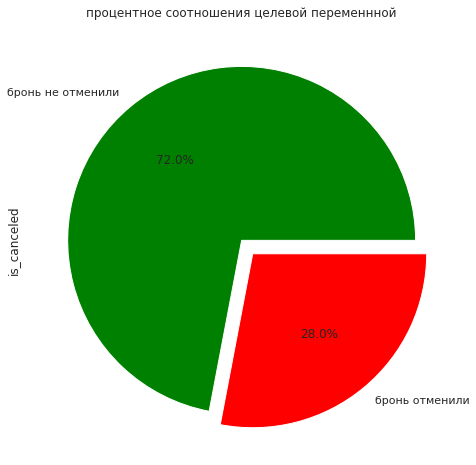

In [33]:
figure, ax=plt.subplots(figsize=(12,8))
labels = 'бронь не отменили' , 'бронь отменили'
colors = 'Green', 'Red'
df['is_canceled'].value_counts().plot.pie(explode=[0,0.1], colors = colors, labels = labels, autopct='%1.1f%%',ax=ax)
ax.set_title('процентное соотношения целевой переменнной')
plt.show()

Дисбаланс целевой переменной почти в 3 раза меньше положительных значений. Нужно будет исправлять. 

### Формулировка ML-задачи на основе бизнес-задачи

Необходимо что бы модель окупилась за тестовый период те условно за 2017 год. Разделим df 

In [34]:
df_train = df[df['arrival_date_year'] != 2017]
df_test = df[df['arrival_date_year'] == 2017]
df_test = df_test.reset_index(drop=True) 
df_train = df_train.reset_index(drop=True)

Для определения прибыли - создадим столбцы с данными по ценам

In [35]:
clean_price = {'A': 400, 'B': 350, 'C': 350,'D': 150, 'E': 150, 'F': 150, 'G': 150}

room_price = {'A': 1000, 'B': 800, 'C': 600,'D': 550, 'E': 500, 'F': 450, 'G': 350}

season_coeff = {'January': 1.0, 'February': 1.0, 'March': 1.2, 'April': 1.2, 'May': 1.2, 'June': 1.4,'July': 1.4, 'August': 1.4, 'September': 1.2, 'October': 1.2, 'November': 1.2, 'December': 1.0}

df_test['clean_price'] = df_test['reserved_room_type'].map(clean_price)
df_test['room_price'] = df_test['reserved_room_type'].map(room_price)
df_test['season_coeff'] = df_test['arrival_date_month'].map(season_coeff)

напишем функцию для подсчета прибыли и создадим столбец income

In [36]:
def income (i):
    if i['is_canceled'] == 0:
        return ((i['total_nights'] * i['room_price']*i['season_coeff']) - ((i['total_nights']//2 + 1) * i['clean_price']))
    else:
        return 0 - (i['room_price']*i['season_coeff']+i['clean_price'])

In [37]:
df_test['income'] = df_test.apply(income, axis=1)

In [38]:
df_test.sample(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,adults,children,meal,country,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,clean_price,room_price,season_coeff,income
2680,0,112,2017,January,2,0,BB,BEL,TA/TO,0,0,A,0,0,Transient,0,2,3,400,1000,1.00,"2,200.00"
22489,0,63,2017,July,1,0,BB,ESP,TA/TO,0,0,A,0,0,Transient,0,0,1,400,1000,1.40,"1,000.00"
20709,0,169,2017,June,2,0,BB,DEU,TA/TO,0,0,D,0,0,Transient,0,0,4,150,550,1.40,"2,630.00"


In [39]:
print ('Прибыль отеля за тестовый период до внедрения модели =',df_test['income'].sum(),'у.е.')

Прибыль отеля за тестовый период до внедрения модели = 32438510.0 у.е.


###  ML

подготовим признаки.

In [40]:
features_train = df_train.drop(['is_canceled','arrival_date_year','arrival_date_month'], axis=1)
target_train = df_train['is_canceled']
features_test = df_test.drop(['is_canceled','arrival_date_year','arrival_date_month','clean_price', 'room_price', 'season_coeff', 'income'], axis=1)
target_test = df_test['is_canceled']

In [41]:
print(features_train.shape)
print (target_train.shape)
print(features_test.shape)
print (target_test.shape)

(42876, 15)
(42876,)
(24372, 15)
(24372,)


скалируем количественные столбцы

In [42]:
numeric = ['lead_time','adults', 'children', 'previous_cancellations','previous_bookings_not_canceled', 'booking_changes','days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests','total_nights']
scaler = RobustScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

кодируем категориальные

In [43]:
categorical = ['meal','country', 'distribution_channel', 'reserved_room_type','customer_type']

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(features_train[categorical])

features_train_encoded = pd.DataFrame(encoder.transform(features_train[categorical]).toarray(),columns=encoder.get_feature_names_out(categorical),index=features_train.index)
features_train = pd.concat((features_train[numeric], features_train_encoded), axis=1)

features_test_encoded = pd.DataFrame(encoder.transform(features_test[categorical]).toarray(),columns=encoder.get_feature_names_out(categorical),index=features_test.index)
features_test = pd.concat((features_test[numeric], features_test_encoded), axis=1)

проверим баланс целевой переменной

In [44]:
target_train.value_counts(normalize = True)

0   0.74
1   0.26
Name: is_canceled, dtype: float64

In [45]:
RANDOM_STATE = 12345

выбор модели. Для подбора гиперпараметров будем использовать GridSearchCV. Для оценки recall_score - нам важна именно полнота что бы не получить убытки. Вычисления закоментирую, вычислялось достаточно долго.

In [46]:
model = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', LogisticRegression())
    ])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']}
]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid = GridSearchCV(model, param_grid, cv= cv,scoring='recall')
grid.fit(features_train, target_train)
print("Лучшая модель: ", grid.best_params_)
print("Лучший результат recall: ", grid.best_score_)

In [47]:
model2 = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', RandomForestClassifier())
    ])
param_grid2 = [
     {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(100,200,10)),
    'classifier__max_depth' : list(range(2,20)),
    'classifier__criterion' :['gini', 'entropy']}
]
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid2 = GridSearchCV(model2, param_grid2, cv=cv2,scoring='recall')
grid.fit(features_train, target_train)

print("Лучшая модель: ", grid.best_params_)
print("Лучший результат recall: ", grid.best_score_)

In [48]:
model3 = Pipeline([
        ('sampling', SMOTE()),
        ('classifier', DecisionTreeClassifier())
    ])
param_grid3 = [
     {'classifier' : [DecisionTreeClassifier()],
    'classifier__max_depth' : list(range(2,10)),
    'classifier__criterion' :['gini', 'entropy']}
]
cv3 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid3 = GridSearchCV(model3, param_grid3, cv= cv3,scoring='recall')
grid.fit(features_train, target_train)

print("Лучшая модель: ", grid.best_params_)
print("Лучший результат recall: ", grid.best_score_)

Лучшая модель:  {'classifier': DecisionTreeClassifier(criterion='entropy', max_depth=2), 'classifier__criterion': 'entropy', 'classifier__max_depth': 2}
Лучший результат recall:  0.9147418047936116


In [49]:
data =  {'модель':['LogisticRegression', 'RandomForestClassifier', 'DecisionTreeClassifier'], 'recall':[ 0.7841908765382042, 0.7841908765382042,0.9173585226726851]} 
df_model = pd.DataFrame(data) 
print (df_model)

                   модель  recall
0      LogisticRegression    0.78
1  RandomForestClassifier    0.78
2  DecisionTreeClassifier    0.92


Удивительно! Модель дерева решений - лучшая! 

проверим  на тестовых данных.

In [50]:
target_test_predict = grid.predict(features_test)
recall_score(target_test, target_test_predict)

0.9528362837575914

Отличный результат. 

Посчитаем прибыль. 

In [51]:
df_test['pred_canceled'] = target_test_predict

In [52]:
df_test.sample(3)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,adults,children,meal,country,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,clean_price,room_price,season_coeff,income,pred_canceled
9696,1,173,2017,May,2,0,BB,DEU,TA/TO,0,0,D,0,0,Transient,0,2,3,150,550,1.20,-810.00,1
13609,0,9,2017,January,2,0,BB,FRA,TA/TO,0,0,D,0,0,Transient,0,2,3,150,550,1.00,"1,350.00",1
6984,1,231,2017,February,2,1,BB,GBR,TA/TO,0,0,A,0,0,Transient,0,0,6,400,1000,1.00,"-1,400.00",1


In [53]:
def profit (i):
    if i['is_canceled'] == 0:
        return ((i['total_nights'] * i['room_price']*i['season_coeff']) - ((i['total_nights']//2 + 1) * i['clean_price']))
    elif i['is_canceled'] == 1 and i['pred_canceled'] == 1:
        return (0-i['room_price']*i['season_coeff']+i['clean_price'])*0.2
    else:
        return 0 - (i['room_price']*i['season_coeff']+i['clean_price'])

In [54]:
def p_profit (i):
    if i['is_canceled'] == 0 and i['pred_canceled'] == 0:
        return ((i['total_nights'] * i['room_price']*i['season_coeff']) - ((i['total_nights']//2 + 1) * i['clean_price']))
    elif i['is_canceled'] == 0 and i['pred_canceled'] == 1:
        return (i['room_price']*i['season_coeff']+i['clean_price'])*0.5
    elif i['is_canceled'] == 1 and i['pred_canceled'] == 1:
        return 0-(i['room_price']*i['season_coeff']+i['clean_price'])*0.2
    else:
        return 0 - (i['room_price']*i['season_coeff']+i['clean_price'])

In [55]:
df_test['profit'] = df_test.apply(profit, axis=1)

In [56]:
df_test['p_profit'] = df_test.apply(p_profit, axis=1)

In [57]:
print ('Оптимистичный сценарий. Общая ожидаемая прибыль за год после внедрения модели:',df_test['profit'].sum() - df_test['income'].sum(),'у.е.')

Оптимистичный сценарий. Общая ожидаемая прибыль за год после внедрения модели: 8933136.0 у.е.


In [58]:
print ('Писсимистичный сценарий. Общая ожидаемая прибыль за год после внедрения модели:',df_test['p_profit'].sum() - df_test['income'].sum(),'у.е.')

Писсимистичный сценарий. Общая ожидаемая прибыль за год после внедрения модели: -18864719.0 у.е.


Очень неожиданно (может быть только для меня) модель решающего дерева с подобранными гиперпараметрами оказалась лучше в оценке полноты чем лог. регрессия и случайный лес!
Модель явно окупается. Общая ожидаемая прибыль за год после внедрения модели сотавляет 8млн. и превышает затраты в 400.000. Но есть пессимимстичный сценарий когда 50% откажутся от брони на раннм этапе из за депозита и тогда отель понесет убытки. 

###  портрет «ненадёжного» клиента

опишем признаки не надежного клиента

In [59]:
print (df.groupby('meal')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(3))
print (df.groupby('country')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(3))
print (df.groupby('distribution_channel')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(3))
print (df.groupby('reserved_room_type')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(3))
print (df.groupby('customer_type')['is_canceled'].agg(['mean', 'count']).sort_values('mean', ascending=False).head(3))

      mean  count
meal             
SC    0.35   9197
FB    0.30    165
HB    0.27   5193
         mean  count
country             
CHN      0.49    732
BRA      0.37   1721
PRT      0.37  18938
                      mean  count
distribution_channel             
TA/TO                 0.31  54732
GDS                   0.18    168
Direct                0.15   8553
                    mean  count
reserved_room_type             
G                   0.34    849
B                   0.32    921
D                   0.31  13765
                 mean  count
customer_type               
Transient        0.30  56074
Contract         0.19   2199
Transient-Party  0.16   8560


In [60]:
df_canceled=df[df['is_canceled']==1]

In [61]:
df_canceled.describe().T

,count,mean,std,min,25%,50%,75%,max
is_canceled,"18,823.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00
lead_time,"18,823.00",101.42,84.64,0.00,32.00,78.00,154.00,374.00
arrival_date_year,"18,823.00","2,016.30",0.65,"2,015.00","2,016.00","2,016.00","2,017.00","2,017.00"
adults,"18,823.00",1.94,0.48,0.00,2.00,2.00,2.00,4.00
children,"18,823.00",0.14,0.45,0.00,0.00,0.00,0.00,3.00
previous_cancellations,"18,823.00",0.06,0.53,0.00,0.00,0.00,0.00,26.00
previous_bookings_not_canceled,"18,823.00",0.04,0.86,0.00,0.00,0.00,0.00,58.00
booking_changes,"18,823.00",0.16,0.58,0.00,0.00,0.00,0.00,16.00
days_in_waiting_list,"18,823.00",0.76,8.42,0.00,0.00,0.00,0.00,236.00
required_car_parking_spaces,"18,823.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00


Не надежного клиента можно описать как гражданина Китая, Бразилии или Португалии, с дистрибьюцией заказа ТА/ТО (не знаю что это и признак не пояснен), резервирующего D,B,G типа номер и не связаного с договором или групповым заездом, имеет около 80 дней между датой бронирования и датой прибытия, бронирует впервые, на 2 взрослых, на ночи, без детей, без места для парковки, около 1 дня находится в листе ожидания.

### общий вывод

Мы  разрабатывали систему, которая предсказывает отказ от брони. Данные в целом были качественные но было много дубликатов. 
Каждый 4й клиент оменяет бронь. После подбора параметров лучше всего себя показала модель решающего дерева, но подбор осуществляется очень долго. После подсчетов лучшая модель показала хорошую прибыль и при оптимистичном прогнозе быстро окупиться, но при пессимистичном прогнозе, если клиенты начнут отказываться от заселения - можно получить убытки.
Сразу хочется отметить что ввод депозита лучше производить на основании A/B теста. Не известно как клиенты отреагируют на введение депозита и сколько из них в итоге откажется от брони на раннем этапе. Так же можно попробовать выборочно вводить депозит исходя из признаков не надежного клиента.